In [ ]:
import json
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# UFO JSON 파일 불러오기
with open('/data/ephemeral/home/data/chinese_receipt/ufo/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)


# UFO format 데이터로 bounding box 시각화 코드 

In [ ]:
# UFO format 데이터로 bounding box 시각화 코드 
def image_visualization() :
    image_key =  random.choice(list(data['images'].keys()))
    image_data = data['images'][image_key]
    img_path = f"/data/ephemeral/home/data/chinese_receipt/img/train/{image_key}"  # 실제 이미지 경로로 업데이트
    img = cv2.imread(img_path)
    plt.figure(figsize=(20,15))
    if img is None:
        print("이미지를 불러올 수 없습니다. 경로를 확인해주세요:", img_path)
        return
    
    # 경계 상자 그리기
    for word_id, word_data in image_data['words'].items():
        points = word_data['points']
        
        # 그리기용 정수 좌표로 변환
        pts = np.array(points, np.int32).reshape((-1, 1, 2))
        
        # 경계 상자 폴리곤 그리기
        cv2.polylines(img, [pts], isClosed=True, color=(255,0, 0), thickness=2)
        
        
   
    # 이미지를 RGB로 변환 후 matplotlib으로 표시
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    

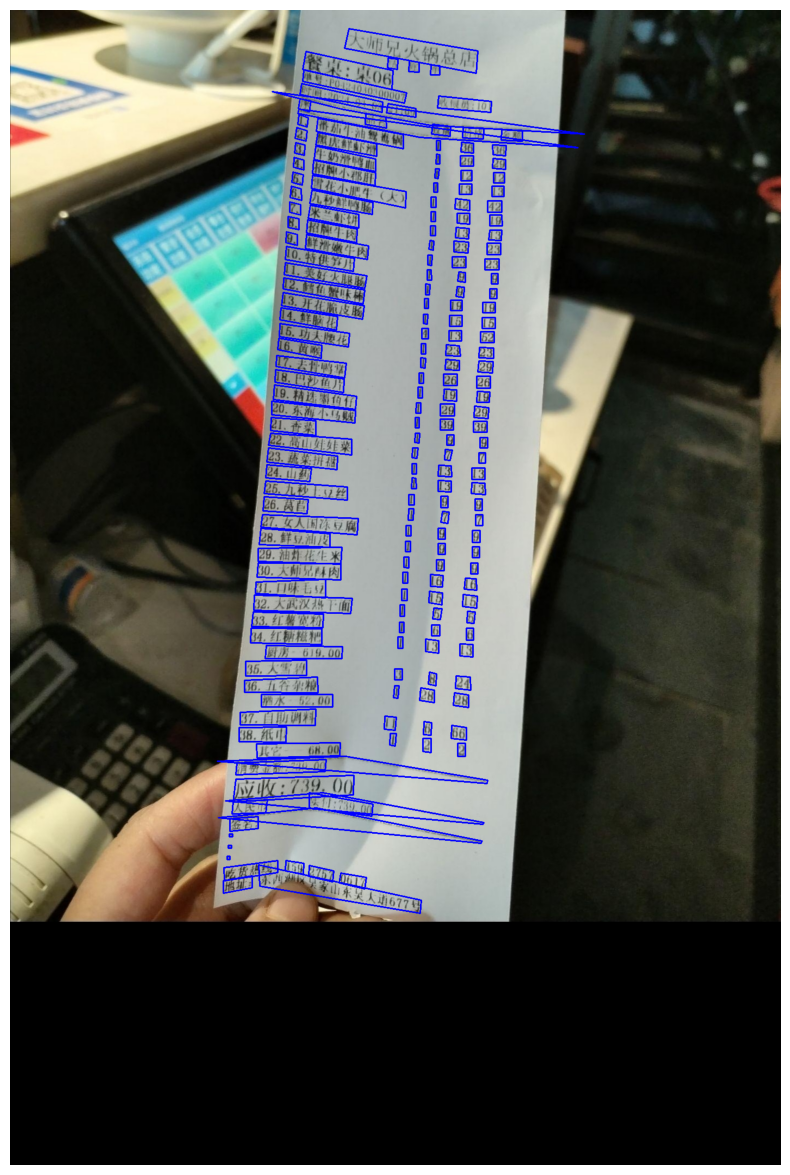

In [6]:
image_visualization()

# COCO segmentation 좌표를 이용한 시각화 

In [ ]:
# COCO JSON 파일 불러오기
with open('/data/ephemeral/home/data/chinese_receipt/coco/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
# COCO segmentation 좌표를 이용한 시각화 
def coco_segmentation_visualization():
    # 이미지 로드
    image_id = 1
    image_data = data['images'][image_id - 1]
    print(image_data)
    img_path = f"/data/ephemeral/home/data/chinese_receipt/img/train/{image_data['file_name']}"  # 실제 이미지 경로로 업데이트
    img = cv2.imread(img_path)
    plt.figure(figsize=(20, 15))
    if img is None:
        print("이미지를 불러올 수 없습니다. 경로를 확인해주세요:", img_path)
        return
    
    # 해당 image_id에 대한 주석 필터링
    annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
    # 세그멘테이션 폴리곤 그리기
    for annotation in annotations:
        for seg in annotation['segmentation']:
            points = np.array(seg, np.int32).reshape((-1, 1, 2))
            cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)

    # matplotlib을 위해 RGB로 변환 후 표시
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    

In [ ]:
coco_segmentation_visualization()

# Albumentation 적용 시각화 

In [ ]:
import albumentations as A
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
# UFO JSON 파일 불러오기
with open('/data/ephemeral/home/data/chinese_receipt/ufo/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [24]:
def Albumentation_Visualization():
    # 랜덤한 이미지 선택
    image_key = random.choice(list(data['images'].keys()))
    image_data = data['images'][image_key]
    img_path = f"/data/ephemeral/home/data/chinese_receipt/img/train/{image_key}"  # 실제 이미지 경로로 업데이트
    img = cv2.imread(img_path)
    
    # 원본 이미지와 변환된 이미지를 나란히 출력하기 위해 figure 설정
    plt.figure(figsize=(20, 10))
    
    # 원본 세그먼트 좌표 준비
    original = []
    for word_id, word_data in image_data['words'].items():
        points = word_data['points']
        
        # 각 점을 (x, y) 튜플 형식으로 변환하여 정수로 저장
        pts = [(int(pt[0]), int(pt[1])) for pt in points]
        original.append(pts)
    
    # Albumentations 변환 정의 (예시로 HorizontalFlip 추가)
    transform = A.Compose([
        A.HorizontalFlip(p=1),  # 항상 수평 뒤집기
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
    
    # Albumentations의 keypoint를 이용해 세그먼트 좌표 변환
    transformed = transform(image=img, keypoints=[tuple(pt) for seg in original for pt in seg])
    transformed_img = transformed['image']
    transformed_keypoints = transformed['keypoints']
    
    # 변환된 세그먼트를 다시 원래 형태로 그룹화
    transformed_segments = []
    idx = 0
    for seg in original:
        seg_len = len(seg)
        transformed_segments.append(np.array(transformed_keypoints[idx: idx + seg_len], np.int32))
        idx += seg_len
    
    # 원본 이미지에 세그먼트 좌표 그리기
    img_with_original_segments = img.copy()
    for seg in original:
        cv2.polylines(img_with_original_segments, [np.array(seg, np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # 변환된 이미지에 세그먼트 좌표 그리기
    img_with_transformed_segments = transformed_img.copy()
    for transformed_seg in transformed_segments:
        cv2.polylines(img_with_transformed_segments, [transformed_seg], isClosed=True, color=(255, 0, 0), thickness=2)
    
    # BGR을 RGB로 변환하여 원본 및 변환된 이미지 시각화
    img_with_original_segments_rgb = cv2.cvtColor(img_with_original_segments, cv2.COLOR_BGR2RGB)
    img_with_transformed_segments_rgb = cv2.cvtColor(img_with_transformed_segments, cv2.COLOR_BGR2RGB)
    
    # 원본 이미지와 변환된 이미지 나란히 출력
    plt.subplot(1, 2, 1)
    plt.imshow(img_with_original_segments_rgb)
    plt.title("original image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_with_transformed_segments_rgb)
    plt.title("transformed image")
    plt.axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=0.2) # 수평, 수직 간격 줄이기
    plt.show()


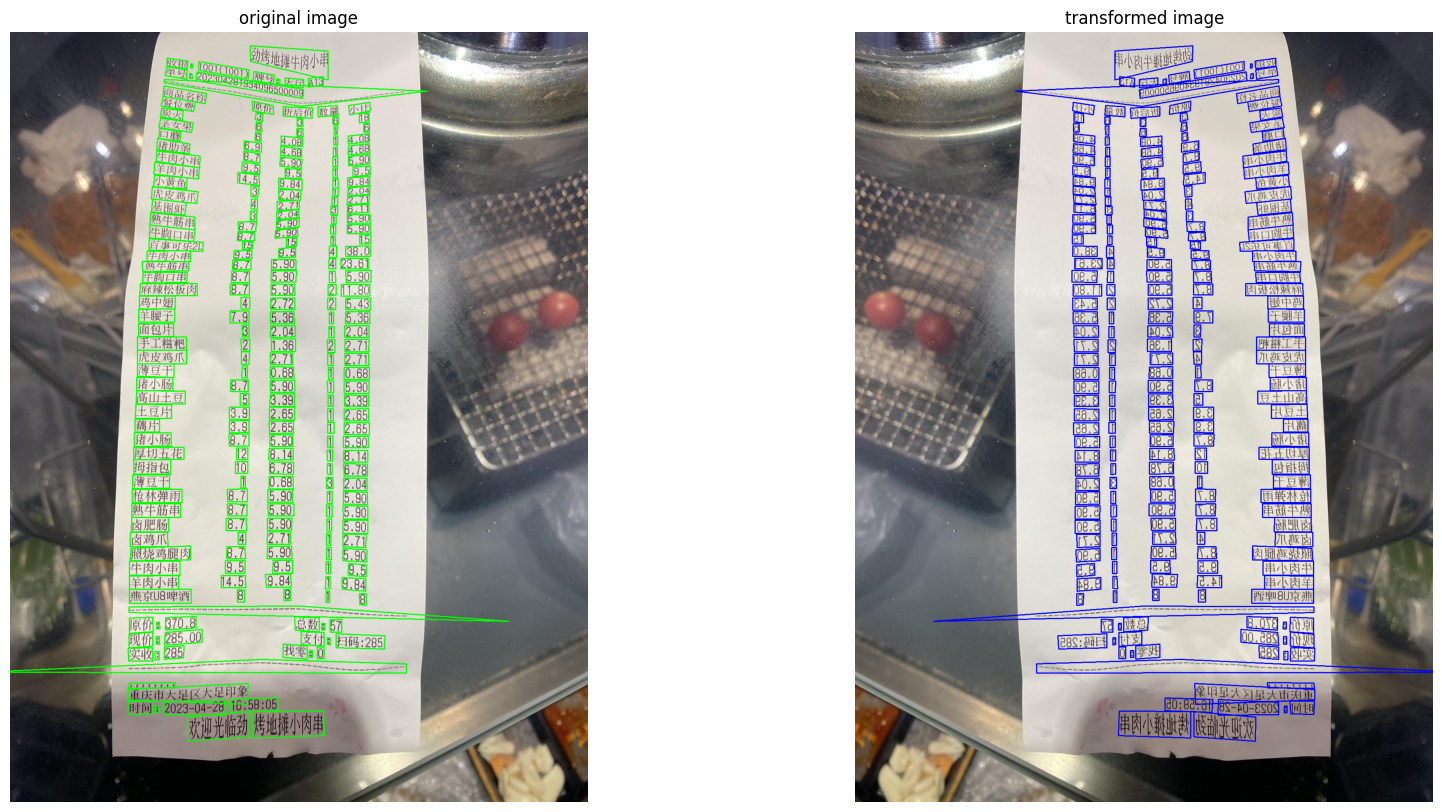

In [30]:
# 함수 호출
Albumentation_Visualization()